In [1]:

import numpy as np
import gymnasium as gym
from gymnasium import spaces
import pandas as pd
import matplotlib.pyplot as plt

class StockTradingEnv(gym.Env):
    def __init__(self, data, initial_balance=10000, commission_fee=0.01, slippage_cost=0.1):
        super(StockTradingEnv, self).__init__()
        self.data = data
        self.current_step = 0
        self.initial_balance = initial_balance
        self.balance = self.initial_balance
        self.stock_owned = 0
        self.date = data['date']
        self.stock_price_history = data['adj_close']
        self.commission_fee = commission_fee
        self.slippage_cost = slippage_cost

        self.action_space = spaces.Box(low=np.array([-1, 0]), high=np.array([1, 1]), shape=(2,))  # (Action, Amount) where Action: -1: Buy, 0: Hold, 1: Sell
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(1,))

        self.render_df = pd.DataFrame()
        self.done = False
        self.current_portfolio_value = initial_balance

    def reset(self, seed = None):
        self.current_step = 0
        self.balance = self.initial_balance
        self.stock_owned = 0
        self.done = False
        self.current_portfolio_value = self.initial_balance
        return self._get_observation(), {}

    def step(self, action):
        assert self.action_space.contains(action)
        prev_portfolio_value = self.balance if self.current_step == 0 else self.balance + self.stock_owned * self.stock_price_history[self.current_step - 1]
        current_price = self.stock_price_history[self.current_step]
        amount = int(self.initial_balance * action[1] / current_price)

        if action[0] > 0:  # Buy
            amount =  min( int(self.initial_balance * action[1] / current_price), int(self.balance / current_price * (1 + self.commission_fee + self.slippage_cost)))
            if self.balance >= current_price * amount * (1 + self.commission_fee + self.slippage_cost):
                self.stock_owned += amount
                self.balance -= current_price * amount * (1 + self.commission_fee + self.slippage_cost)
        elif action[0] < 0:  # Sell
            amount = min(amount, self.stock_owned)
            if self.stock_owned > 0:
                self.stock_owned -= amount
                self.balance += current_price * amount * (1 - self.commission_fee - self.slippage_cost)

        current_portfolio_value = self.balance + self.stock_owned * current_price
        excess_return = current_portfolio_value - prev_portfolio_value
        risk_free_rate = 0.02  # Example risk-free rate
        std_deviation = np.std(self.stock_price_history[:self.current_step + 1])
        sharpe_ratio = (excess_return - risk_free_rate) / std_deviation if std_deviation != 0 else 0
        reward = sharpe_ratio

        self.render(action, amount, current_portfolio_value)
        obs = self._get_observation()

        self.current_step += 1

        if self.current_step == len(self.data['adj_close']):
            done = True
        else:
            done = False

        self.done = done

        info = {}
        return obs, reward, done, False,info


    def _get_observation(self):
        return np.array([
            self.stock_price_history[self.current_step]
        ])

    def render(self, action, amount, current_portfolio_value, mode = None):
        current_date = self.date[self.current_step]
        today_action =  'buy' if action[0] > 0 else 'sell'
        current_price = self.stock_price_history[self.current_step]

        if mode == 'human':
            print(f"Step:{self.current_step}, Date: {current_date}, Market Value: {current_portfolio_value:.2f}, Balance: {self.balance:.2f}, Stock Owned: {self.stock_owned}, Stock Price: {current_price:.2f}, Today Action: {today_action}:{amount}")
        else:
            pass
        dict = {
            'Date': [current_date], 'market_value': [current_portfolio_value], 'balance': [self.balance], 'stock_owned': [self.stock_owned], 'price': [current_price], 'action': [today_action], 'amount':[amount]
        }
        step_df = pd.DataFrame.from_dict(dict)
        self.render_df = pd.concat([self.render_df, step_df], ignore_index=True)

    def render_all(self):
        df = self.render_df.set_index('Date')
        fig, ax = plt.subplots(figsize=(18, 6))
        df.plot( y="market_value" , use_index=True,  ax = ax, style='--' , color='lightgrey')
        df.plot( y="price" , use_index=True,  ax = ax , secondary_y = True , color='black')

        for idx in df.index.tolist():
            if (df.loc[idx]['action'] == 'buy') & (df.loc[idx]['amount'] > 0):
                plt.plot(
                    idx,
                    df.loc[idx]["price"] - 1,
                    'g^'
                )
                plt.text(idx, df.loc[idx]["price"]- 3, df.loc[idx]['amount'] , c= 'green',fontsize=8, horizontalalignment='center', verticalalignment='center')
            elif (df.loc[idx]['action'] == 'sell') & (df.loc[idx]['amount'] > 0):
                plt.plot(
                    idx,
                    df.loc[idx]["price"] + 1,
                    'rv'
                    )
                plt.text(idx, df.loc[idx]["price"] + 3, df.loc[idx]['amount'], c= 'red',fontsize=8, horizontalalignment='center', verticalalignment='center')

In [7]:

from stable_baselines3 import DQN
from pybroker import YFinance
import pybroker
pybroker.enable_data_source_cache('yfinance')
import pandas as pd
from stable_baselines3 import PPO

yfinance = YFinance()
df = yfinance.query(['AAPL'], start_date='3/1/2021', end_date='3/1/2022')
df['date'] = pd.to_datetime(df['date']).dt.date
env = StockTradingEnv(df, initial_balance=100000, commission_fee=0.0001, slippage_cost=0.005)

model = PPO("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=1000)


Loaded cached bar data.



J:\Projects\DLproject\ModelTesting\DeepReinforcmentLearning\.venv\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

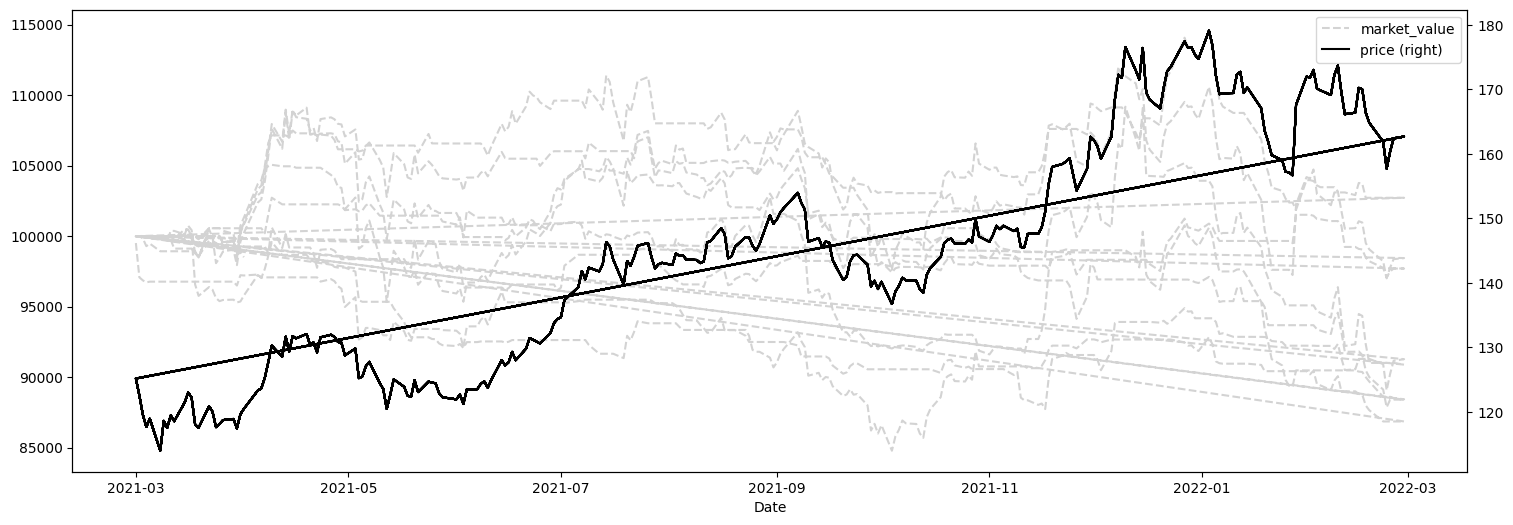

In [9]:
env.render_all()